# Break Down of the TSNE Plots 
I am here to provide some insights about the clustering structure of the the base

## Imports

In [34]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [35]:
import pandas as pd
import numpy as np 
import networkx as nx
from networkx import algorithms 
import math
from numpy import arctan2, sin, cos, sqrt, radians
from pyproj import Geod

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import osmnx as ox
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

## Making the graph for our data:


In [3]:
graph = ox.graph_from_address('Athens, Municipality of Athens, Regional Unit of Central Athens, Attica, 10667, Greece', network_type='drive')  

## Data.py Functions:
I am modifying on the data.py functions to concate the dataframes from different blocks .

In [4]:
 def process_csv(name):
        "pre processing function to turn csv file into usable material for `process`"
        in_fname = name

        with open(in_fname, "r") as f:
            temp = f.readlines()
    
        rows = temp[1:]
        return rows

In [5]:
def process(row_str, H, D, col_names, idx_names):
        "Creates multi index table using 'track_id' and 'time' as the indexes. Only creates table for each index."
        parts = row_str.strip().strip(";").split(";")
        header = parts[:H]
        data = np.array(parts[H:], dtype=np.float)
        data = data.reshape(-1, D)

        # create MultiIndex from id and time
        timesteps = data[:,-1]
        id_arr = np.full(timesteps.shape, int(header[0].strip()))
        tups = list(zip(id_arr, timesteps))
        mul = pd.MultiIndex.from_tuples(tups, names=idx_names)

        data = data[:,:-1] # exclude time from data
        df = pd.DataFrame(data, columns=col_names, index=mul)
        df = df.assign(
            type=header[1].strip(),
            traveled_d=float(header[2]),
            avg_speed=float(header[3])
        )
        return df

In [6]:
def create(csv_file):
        H = 4 #header length 
        D = 6 #data length
        idx_names = ['id', 'time']
        col_names = ['lat', 'lon', 'speed', 'lon_acc', 'lat_acc']
        a = process_csv(csv_file)
        frames = [process(a[i], H, D, col_names, idx_names) for i in range(len(a))]
        df = pd.concat(frames)
        return df

## Feature Engineering and Aggregating functions:
I am modifying some of the feature engineering functions and creating a couple of aggregating functions. 

In [7]:
def median(df):
    medians = []
    medians.append(df.iloc[0]['type'])
    for i in ['speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing']:
        medians.append(np.median(df[i].dropna()))
    return medians

In [8]:
def AVG(df):
    avgs = []
    avgs.append(df.iloc[0]['type'])
    for i in ['speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing']:
        avgs.append(np.average(df[i].dropna()))
    return avgs

In [9]:
def stdev(df):
    stdevss = []
    stdevss.append(df.iloc[0]['type'])
    for i in ['speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing']:
        stdevss.append(np.median(df[i].dropna()))
    return medians

In [10]:
def Greek_aggregate(df):
    avgs = [df.iloc[0]['type']]
    meds = [df.iloc[0]['type']]
    stds = [df.iloc[0]['type']]
    for i in df.columns:
        if i == 'id' or i == 'type':
            continue
        avgs.append(np.average(df[i].dropna()))
        meds.append(np.median(df[i].dropna()))
        stds.append(np.std(df[i].dropna()))
    return [avgs, meds, stds]
    

In [11]:
def bearing(df):
    """calculates and adds bearing column to dataframe
    Example usage:
        df = csv_to_df('sample.csv')
        df = bearing(df)
    """
    df['bearing'] = \
        df.groupby('id', as_index=False, group_keys=False) \
        .apply(__calc_bearings)
    return df

In [12]:
def __bearing(c1, c2):
    """credit to https://bit.ly/3amjz0Q for bearing formula"""
    lat1,lon1 = c1
    lat2,lon2 = c2
    
    dL = lon2 - lon1
    x = cos(lon2) * sin(dL)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dL)
    return arctan2(x,y)

In [13]:
def __calc_bearings(df):
    """returns a multi-indexed dataframe of bearings at each timestep for vehicle with specified ID"""
    df1 = df
    df2 = df.shift(-1)

    c1 = (df1['lat'], df1['lon'])
    c2 = (df2['lat'], df2['lon'])
    df3 = __bearing(c1, c2)
    return df3

In [14]:
def __calc_directions(df):
    df1 = df
    df2 = df.shift(-1)
    df3 = (df1['edge_progress'] < df2['edge_progress']).astype(int)
    if len(df3) > 1:
        df3.iloc[-1] = df3.iloc[-2]
    return df3

In [24]:
def __construct_graph_data_cols(graph):
    def aux(row):
        coord = (row['lat'],row['lon'])
        # nn = ox.get_nearest_node(graph, coord)
        start, end, _ = ox.get_nearest_edge(graph, coord)
        if start > end:
            start, end = end, start
        # row['nearest_node'] = nn
        row['nearest_edge_start_node'] = start
        row['nearest_edge_end_node'] = end
        row['edge_progress']  = __edge_progress(row, graph)
        return row
    return aux

In [15]:
 def nearest_graph_data(df, graph):
    """uses osmnx to find nearest node and edge data, calculates 
    progress along nearest edge as a ratio, and adds these features
    as columns to the dataframe
    Example usage:
        df = csv_to_df('sample.csv')
        graph = ox.graph_from_address('address_here', network_type='drive') 
        df = nearest_graph_data(df, graph)
    """
    df['nearest_node'],             \
    df['nearest_edge_start_node'],  \
    df['nearest_edge_end_node'],    \
    df['edge_progress']             \
        = zip(*df.apply(__construct_graph_data_cols(graph), axis=1))
    return df

In [29]:
def __edge_progress(row, graph):
    edge_start_node = row['nearest_edge_start_node']
    edge_end_node = row['nearest_edge_end_node']

    lon_start, lat_start = graph.nodes[edge_start_node]['x'], graph.nodes[edge_start_node]['y']
    lon_end, lat_end = graph.nodes[edge_end_node]['x'], graph.nodes[edge_end_node]['y']
    lon_v, lat_v = row[['lon', 'lat']]

    geod = Geod(ellps='WGS84')
    _,_,a = geod.inv(lon_start, lat_start, lon_end, lat_end)
    _,_,b = geod.inv(lon_start, lat_start, lon_v, lat_v)
    return b/a

In [16]:
def direction(df):
    """adds column that determiens which direction the vehicle is moving along an edge.
    1 if moving from node with smaller id to node with larger id, 0 otherwise.
    Note: `nearest_graph_data` must have been run on this df, otherwise this will fail!
    Example usage:
        df = csv_to_df('sample.csv')
        df = direction(df)
    """
    df['dir'] = \
        df.groupby(
            ['id', 'nearest_edge_start_node', 'nearest_edge_end_node'], 
            as_index=False, group_keys=False) \
        .apply(__calc_directions)
    return df

In [33]:
 def _calc_vehicle_density(df):
    """returns a dataframe of the unique edges (nearest_edge_start_node and neares_edge_end_node pairs) per direction (0 or 1) for edge progress intervals (in the          range(0.0:0.9), 0.0 represents edge progress between 0-10%, 0.1 represents edge progress between 10-20% and so on. 
        df must have been processed by `direction` first. Example usage: 
        df = csv_to_df(csv.file)
        graph = ox.graph_from_address('Athens, Municipality of Athens, Regional Unit of Central Athens, Attica, 10667, Greece', network_type='drive')  
        df = nearest_graph_data(df,graph)
        df = direction(df)
        vehicle_densities = _calc_vehicle_density(df)
     """
    df['edge_progress_intervals'] = df.groupby(['nearest_edge_start_node'])['edge_progress'].transform(lambda x: x-x%0.1)
    df2 = df.reset_index().groupby(['nearest_edge_start_node','nearest_edge_end_node','dir','edge_progress_intervals']).agg({'id':['nunique']})
    return df2

In [17]:
def cross_track_dist(latA1,lonA1,latA2,lonA2,latB,lonB):
    frame = nv.FrameE(a=6371e3, f=0)
    
    pointA1 = frame.GeoPoint(latA1, lonA1, degrees=True)
    pointA2 = frame.GeoPoint(latA2, lonA2, degrees=True)
    pointB = frame.GeoPoint(latB, lonB, degrees=True)
    pathA = nv.GeoPath(pointA1, pointA2)

    s_xt = pathA.cross_track_distance(pointB, method='greatcircle')
    d_xt = pathA.cross_track_distance(pointB, method='euclidean')
    
    if(s_xt<0):
        s_xt=-1*s_xt
    
    val_txt = '{:4.2f}'.format(s_xt/1000)
    return val_txt

In [18]:
def func(graph, start_node, end_node, lat, lon):
     return cross_track_dist(graph.nodes[start_node]['y'],graph.nodes[start_node]['x'],
                                        graph.nodes[end_node]['y'],graph.nodes[end_node]['x'],lat,lon)

In [19]:
def cross_track(df,graph):
    df['Cross Track'] = df.apply(lambda x: func(graph,x['nearest_edge_start_node'],x['nearest_edge_end_node'],x['lat'],x['lon']),axis=1)
    return df

In [20]:
def edge_average_speed(df):
    """returns a dataframe of the average speed of each edge (nearest_edge_start_node 
    and nearest_edge_end_node pairs) for both directions(0 or 1)
        df = Data('sample.csv').df
        graph = ox.graph_from_address('address_here', network_type='drive')  
        df = nearest_graph_data(df,graph)
        df = direction(df)
        edge_average_speed(df)
     """
    _,df["time_stamp"] = list(zip(*df.index))
    df['edge_progress_intervals'] = df                          \
        .groupby(['nearest_edge_start_node'])['edge_progress']  \
        .transform(lambda x: x-x%0.1)                           \

    df2 = df                            \
        .reset_index()                  \
        .groupby([                      \
            'nearest_edge_start_node',  \
            'nearest_edge_end_node',    \
            'edge_progress_intervals',  \
            'dir','time_stamp'])['speed']            \
        .mean()
    
    return df2

In [21]:
def vehicle_density(df):
    """returns a dataframe of the unique edges (nearest_edge_start_node and neares_edge_end_node pairs) 
    per direction (0 or 1) for edge progress intervals (in the range(0.0:0.9), 0.0 represents edge progress 
    between 0-10%, 0.1 represents edge progress between 10-20% and so on. 
        df must have been processed by `direction` first. Example usage: 
        df = csv_to_df(csv.file)
        graph = ox.graph_from_address('address_here', network_type='drive')  
        df = nearest_graph_data(df,graph)
        df = direction(df)
        vehicle_density(df)
     """
    _,df["time_stamp"] = list(zip(*df.index))
    df['edge_progress_intervals'] = df                          \
        .groupby(['nearest_edge_start_node'])['edge_progress']  \
        .transform(lambda x: x-x%0.1)

    df2 = df                                \
        .reset_index()                      \
        .groupby([                          \
            'nearest_edge_start_node',      \
            'nearest_edge_end_node',        \
            'dir',                          \
            'edge_progress_intervals','time_stamp'])     \
        .agg({'id':['nunique']})
    return df2


In [30]:
def features(df):
    df1 = bearing(df)
    df1 = nearest_graph_data(df1, graph)
    df1 = direction(df1)
    df1 = cross_track(df1,graph)
    df1 = edge_average_speed(df1)
    df1 = vehicle_density(df1)
    return df1

## Data overview and readings:

In [37]:
bl = 'Block' 
check = 0
dft = create('./data/Block1.csv')
dft = features(dft)
dft.head()
# for i in range(1, 11):
#     fil = bl+str(i)+'.csv'
#     df1 = create(fil)
#     df1 = bearing(df1)
#     check += len(df1)
#     if i != 1: # I only ran it once for run-time cost
#         dft = pd.concat([dft, df1], axis=0)
#     df2 = df1.reset_index()
#     df2.iloc[]

KeyboardInterrupt: 

In [37]:
meds = []
avgs = []
stds = []
for i in np.unique(df['id']):
    rest = Greek_aggregate(df[df['id']==i])
    avgs.append(rest[0])
    meds.append(rest[1])
    stds.append(rest[2])
    

In [40]:
a = Greek_aggregate(df[df['id']==12])
df_meds = pd.DataFrame(meds, columns = ['type','traj', 'time', 'lat', 'lon', 'speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing', 'edge_progress', 'dir', 'edge_progress_intervals', 'vehicle_density', 'avg_surr_speed','edge_id'] )
df_stds = pd.DataFrame(stds, columns = ['type','traj', 'time', 'lat', 'lon', 'speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing', 'edge_progress', 'dir', 'edge_progress_intervals', 'vehicle_density', 'avg_surr_speed','edge_id'] )
df_avgs = pd.DataFrame(avgs, columns = ['type','traj', 'time', 'lat', 'lon', 'speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing', 'edge_progress', 'dir', 'edge_progress_intervals', 'vehicle_density', 'avg_surr_speed','edge_id'] )

In [45]:
X1 = df_meds.copy()
X1 = X1.drop(['type', 'traj', 'lon_acc', 'lat_acc', 'dir'], axis=1)

,time,lat,lon,speed,traveled_d,avg_speed,bearing,edge_progress,edge_progress_intervals,vehicle_density,avg_surr_speed
0,29.98,37.979350,23.733848,21.45015,296.50,15.931194,-0.113837,0.274944,0.2,3.0,29.780687
1,29.98,37.979086,23.733930,28.28450,439.34,17.080056,-0.127846,0.227088,0.2,3.0,29.872350
2,29.98,37.976078,23.735734,5.57230,177.77,5.765368,-0.333810,0.339406,0.3,3.0,10.391421
3,29.98,37.976094,23.735425,3.96550,165.69,5.616480,-0.170246,0.235451,0.2,3.0,11.556033
4,389.98,37.977603,23.733520,0.00000,195.00,0.898406,0.000000,0.754764,0.7,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
76,149.98,37.978507,23.734374,0.00000,36.86,0.402557,0.000000,0.794943,0.7,1.0,0.000000
77,29.98,37.975668,23.735686,0.00000,110.72,3.877228,0.000000,0.175647,0.1,2.0,0.576200
78,29.98,37.975726,23.735692,0.00000,142.80,4.557538,0.000000,0.119782,0.1,2.0,0.576200
79,29.98,37.975838,23.735703,0.00000,125.44,3.961417,0.000000,0.048463,0.0,1.0,9.347150


In [59]:
X2 = df_stds.copy()
X2 = X2.drop(['type'], axis=1)
X3 = df_avgs.copy()
X3 = X3.drop(['type', 'traj', 'time'], axis=1)

## TSNE Plots with different preplexities 

We begin with the following aggregation method:
### Median of Inputs:

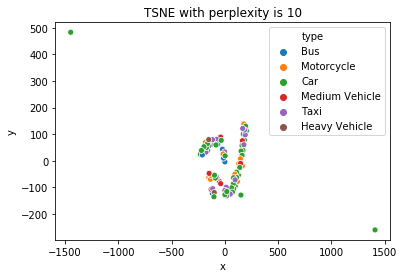

In [51]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(X1)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_meds.index)
dff = pd.concat([df_meds, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 10")
plt.show()

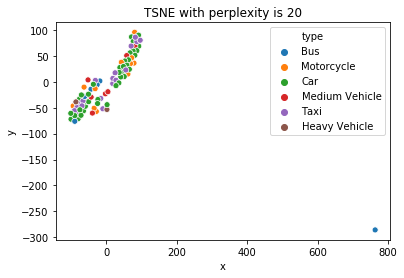

In [52]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=20, random_state=1000)
data_tsne = tsne.fit_transform(X1)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_meds.index)
dff = pd.concat([df_meds, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 20")
plt.show()

#from the below graph, we notice that K-means might be working with median aggregation 

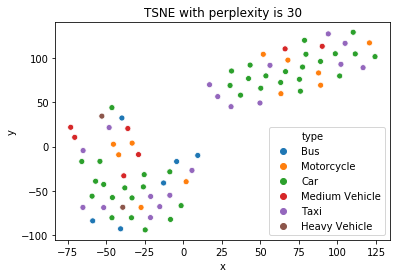

In [53]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
data_tsne = tsne.fit_transform(X1)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_meds.index)
dff = pd.concat([df_meds, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 30")
plt.show()

There is not point to go beyond 30, because the data set here is small. Then, we continue with the:
### Standard Deviation (STD/STDEV) of Inputs:

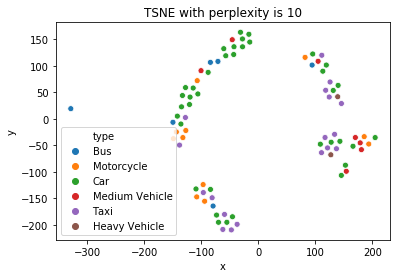

In [54]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(X2)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_stds.index)
dff = pd.concat([df_stds, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 10")
plt.show()

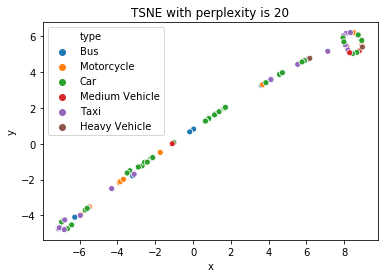

In [56]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=20, random_state=1000)
data_tsne = tsne.fit_transform(X2)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_stds.index)
dff = pd.concat([df_stds, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 20")
plt.show()
#from the below graph, we see that linkage algorithms might work with stdevs aggregation

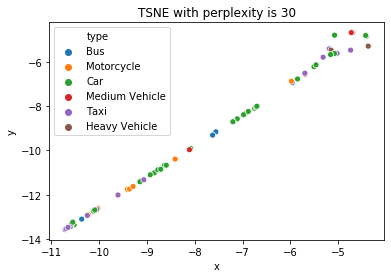

In [57]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
data_tsne = tsne.fit_transform(X2)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_stds.index)
dff = pd.concat([df_stds, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 30")
plt.show()

### Average of Inputs:

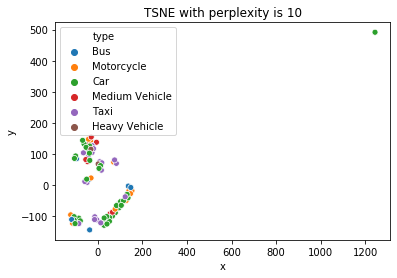

In [60]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(X3)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_avgs.index)
dff = pd.concat([df_avgs, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 10")
plt.show()

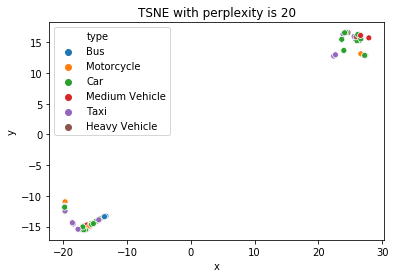

In [61]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=20, random_state=1000)
data_tsne = tsne.fit_transform(X3)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_avgs.index)
dff = pd.concat([df_avgs, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 20")
plt.show()
# here we notice that a fuzzy-c mean or GMM algorithm might work.

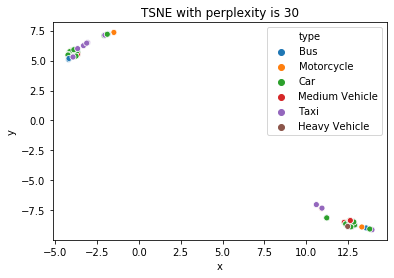

In [62]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
data_tsne = tsne.fit_transform(X3)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df_avgs.index)
dff = pd.concat([df_avgs, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 30")
plt.show()

In [63]:
df_meds.to_csv('medians.csv')

In [64]:
df_avgs.to_csv('avgs.csv')

In [65]:
df_stds.to_csv('stdevs.csv')